In [468]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from sklearn.neighbors import KNeighborsClassifier


# Importing Datasets

In [469]:
train_df = pd.read_csv('data/BTCUSDT-1h-2024-09-Training.csv')
# train_df = pd.read_csv('data/btcusd_1-min_data.csv')
test_df = pd.read_csv('data/BTCUSDT-1h-2024-10-Testing.csv')

In [470]:
train_df.head() # checking entries

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1725148800000,58941.9,59052.7,58872.0,58905.4,1896.832,1725152399999,1.118401e+08,38132,1074.962,6.338599e+07,0
1,1725152400000,58905.3,58934.9,58800.0,58804.1,1978.701,1725155999999,1.164691e+08,39164,932.351,5.488408e+07,0
2,1725156000000,58804.1,58830.8,58250.0,58513.1,12370.124,1725159599999,7.235460e+08,169032,5965.787,3.489416e+08,0
3,1725159600000,58513.1,58652.9,58352.7,58501.6,4842.380,1725163199999,2.834375e+08,67110,2281.402,1.335735e+08,0
4,1725163200000,58501.6,58575.7,58320.2,58410.9,4410.898,1725166799999,2.578041e+08,61080,1972.557,1.153275e+08,0


In [471]:
test_df.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1727740800000,63327.60,63606.00,63006.70,63531.99,1336.93335,1727744399999,8.465134e+07,263946,686.54962,4.347764e+07,0
1,1727744400000,63532.00,63639.86,63370.01,63458.00,1004.08763,1727747999999,6.377684e+07,143076,435.15139,2.764239e+07,0
2,1727748000000,63458.00,63458.00,63180.00,63443.76,716.11822,1727751599999,4.535853e+07,95164,283.92004,1.798136e+07,0
3,1727751600000,63443.76,63744.00,63430.00,63723.48,822.21265,1727755199999,5.230623e+07,110553,500.79186,3.185864e+07,0
4,1727755200000,63723.47,63879.81,63652.06,63868.94,778.75286,1727758799999,4.967721e+07,110722,452.48517,2.886668e+07,0


### Checking Ignore Column

In [472]:
train_df['ignore'].unique()  # checking the unique values in the 'ignore' col/feature 

array([0])

In [473]:
# ignore looks like all 0 values doesn't seem significant going to drop "literally says ignore"
train_df.drop(columns=['ignore'],inplace=True)
test_df.drop(columns=['ignore'],inplace=True)

In [474]:
# checking for ignore col
train_df.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume'],
      dtype='object')

In [475]:
test_df.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume'],
      dtype='object')

### Making Dataset go Day by Day instead of hour by hour

In [476]:
# Convert timestamp from scientific notation to datetime
train_df['open_time'] = pd.to_datetime(train_df['open_time'], unit='ms')

# Set Date as index and resample to daily level
# Using 'last' for price columns and 'sum' for volume
daily_train_df = train_df.set_index('open_time').resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).reset_index()

# Remove timezone information if present
daily_train_df['open_time'] = daily_train_df['open_time'].dt.date


# Get the latest date from the DataFrame
latest_date = daily_train_df['open_time'].max()

In [477]:
# creating predictive data for next 31 days(month of october)
for i in range(1,32):
    next_date = pd.to_datetime(latest_date) + pd.Timedelta(days=i)

    # Create a new row with zeros
    new_row = pd.DataFrame({
        'open_time': [next_date],
        'open': [0],
        'high': [0],
        'low': [0],
        'close': [0],
        'volume': [0]
    })

    # Concatenate the new row to the existing DataFrame
    daily_train_df = pd.concat([daily_train_df, new_row], ignore_index=True)


In [478]:
# Output the train_df that we modified
daily_train_df.head(61)

,open_time,open,high,low,close,volume
0,2024-09-01,58941.9,59052.7,57123.0,57268.1,222909.914
1,2024-09-02,57268.1,59412.3,57093.0,59112.1,201218.384
2,2024-09-03,59112.2,59790.0,57320.0,57451.9,230196.497
3,2024-09-04,57452.0,58500.0,55555.0,57944.8,326983.311
4,2024-09-05,57944.8,58318.9,55600.0,56145.7,294703.592
...,...,...,...,...,...,...
56,2024-10-27 00:00:00,0.0,0.0,0.0,0.0,0.000
57,2024-10-28 00:00:00,0.0,0.0,0.0,0.0,0.000
58,2024-10-29 00:00:00,0.0,0.0,0.0,0.0,0.000
59,2024-10-30 00:00:00,0.0,0.0,0.0,0.0,0.000


(array([19967., 19971., 19975., 19979., 19983., 19987., 19991., 19995.]),
 [Text(19967.0, 0, '2024-09-01'),
  Text(19971.0, 0, '2024-09-05'),
  Text(19975.0, 0, '2024-09-09'),
  Text(19979.0, 0, '2024-09-13'),
  Text(19983.0, 0, '2024-09-17'),
  Text(19987.0, 0, '2024-09-21'),
  Text(19991.0, 0, '2024-09-25'),
  Text(19995.0, 0, '2024-09-29')])

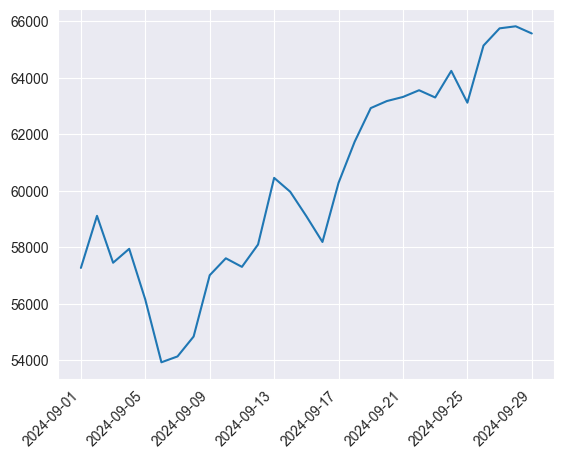

In [479]:
plt.plot(daily_train_df['open_time'].iloc[:-32], daily_train_df['close'].iloc[:-32])
plt.xticks(rotation=45, ha='right')


### Same thing here fixing the format to go day by day

In [480]:
# doing the same thing above to the test_df
test_df['open_time'] = pd.to_datetime(test_df['open_time'], unit='ms')

# Set Date as index and resample to daily level
# Using 'last' for price columns and 'sum' for volume
daily_test_df = test_df.set_index('open_time').resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).reset_index()

# Remove timezone information if present
daily_test_df['open_time'] = daily_test_df['open_time'].dt.date


# Get the latest date from the DataFrame
latest_date = daily_test_df['open_time'].max()


In [481]:
daily_test_df.head(31)

,open_time,open,high,low,close,volume
0,2024-10-01,63327.60,64130.63,60164.00,60805.78,43671.48108
1,2024-10-02,60804.92,62390.31,60000.00,60649.28,31534.70118
2,2024-10-03,60649.27,61477.19,59828.11,60752.71,26221.43472
3,2024-10-04,60752.72,62484.85,60459.90,62086.00,21294.65994
4,2024-10-05,62086.00,62370.56,61689.26,62058.00,7807.46141
5,2024-10-06,62058.01,62975.00,61798.97,62819.91,8906.86177
6,2024-10-07,62819.91,64478.19,62128.00,62224.00,25966.18520
7,2024-10-08,62224.01,63200.00,61860.31,62160.49,19702.22371
8,2024-10-09,62160.50,62543.75,60301.00,60636.02,20011.15684
9,2024-10-10,60636.01,61321.68,58946.00,60326.39,23967.92481


(array([19997., 20001., 20005., 20009., 20013., 20017., 20021., 20025.,
        20028.]),
 [Text(19997.0, 0, '2024-10-01'),
  Text(20001.0, 0, '2024-10-05'),
  Text(20005.0, 0, '2024-10-09'),
  Text(20009.0, 0, '2024-10-13'),
  Text(20013.0, 0, '2024-10-17'),
  Text(20017.0, 0, '2024-10-21'),
  Text(20021.0, 0, '2024-10-25'),
  Text(20025.0, 0, '2024-10-29'),
  Text(20028.0, 0, '2024-11-01')])

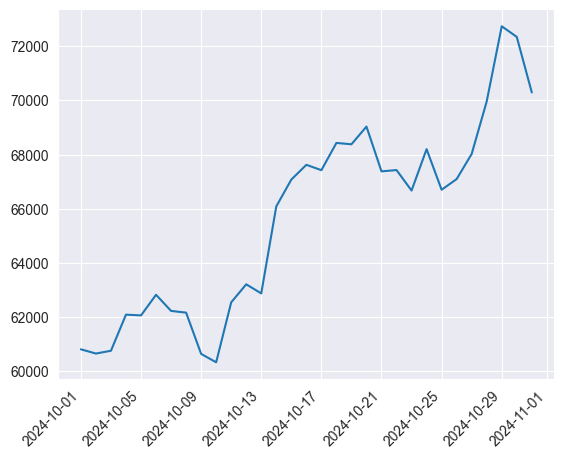

In [482]:
plt.plot(daily_test_df['open_time'], daily_test_df['close'])
plt.xticks(rotation=45, ha='right')

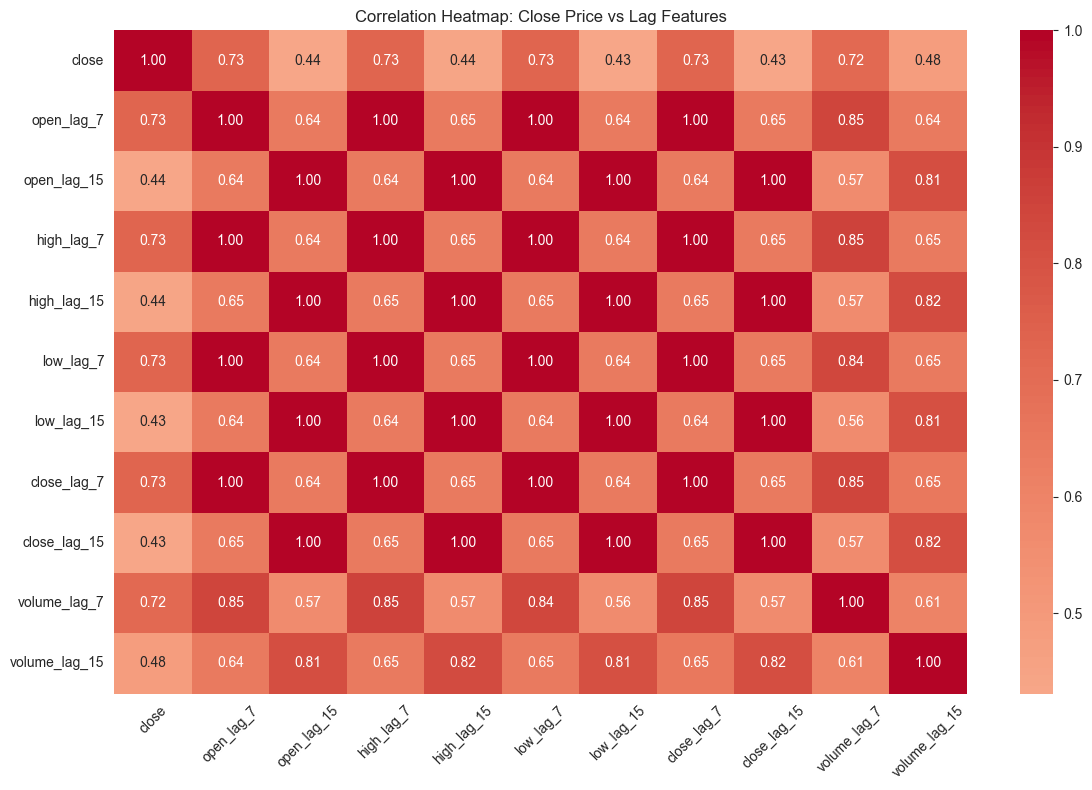


Correlations with Close price:
close            1.000000
high_lag_7       0.731225
close_lag_7      0.730632
open_lag_7       0.728902
low_lag_7        0.726996
volume_lag_7     0.716715
volume_lag_15    0.477631
high_lag_15      0.437742
open_lag_15      0.436648
close_lag_15     0.433881
low_lag_15       0.430903
Name: close, dtype: float64


/var/folders/b5/v7fsmnzj7jg3tj7s1qq57q7w0000gn/T/ipykernel_98584/1939601253.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_train_df_clean = daily_train_df.fillna(method='ffill')


In [483]:
# Assuming daily_data is your DataFrame
# Create lag features for each column except Date
columns_to_lag = ['open', 'high', 'low', 'close', 'volume']
lags = [7,15]

# Create lag features
for col in columns_to_lag:
    for lag in lags:
        daily_train_df[f'{col}_lag_{lag}'] = daily_train_df[col].shift(lag)

# Calculate correlations with Close price
# We'll focus on the correlations between Close and all lag features
lag_columns = [col for col in daily_train_df.columns if 'lag' in col]

correlation_data = daily_train_df[['close'] + lag_columns].corr()['close'].sort_values(ascending=False)

# Create a correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(daily_train_df[['close'] + lag_columns].corr(),
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f')
plt.title('Correlation Heatmap: Close Price vs Lag Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print correlations with Close price
print("\nCorrelations with Close price:")
print(correlation_data)

# Drop rows with NaN values created by the lag features if needed
daily_train_df_clean = daily_train_df.fillna(method='ffill')

In [484]:
correlations = daily_train_df[['close'] + lag_columns].corr()['close'].sort_values(ascending=False)

In [485]:
print(correlations)

close            1.000000
high_lag_7       0.731225
close_lag_7      0.730632
open_lag_7       0.728902
low_lag_7        0.726996
volume_lag_7     0.716715
volume_lag_15    0.477631
high_lag_15      0.437742
open_lag_15      0.436648
close_lag_15     0.433881
low_lag_15       0.430903
Name: close, dtype: float64


In [486]:
print(correlations[1:11])

high_lag_7       0.731225
close_lag_7      0.730632
open_lag_7       0.728902
low_lag_7        0.726996
volume_lag_7     0.716715
volume_lag_15    0.477631
high_lag_15      0.437742
open_lag_15      0.436648
close_lag_15     0.433881
low_lag_15       0.430903
Name: close, dtype: float64


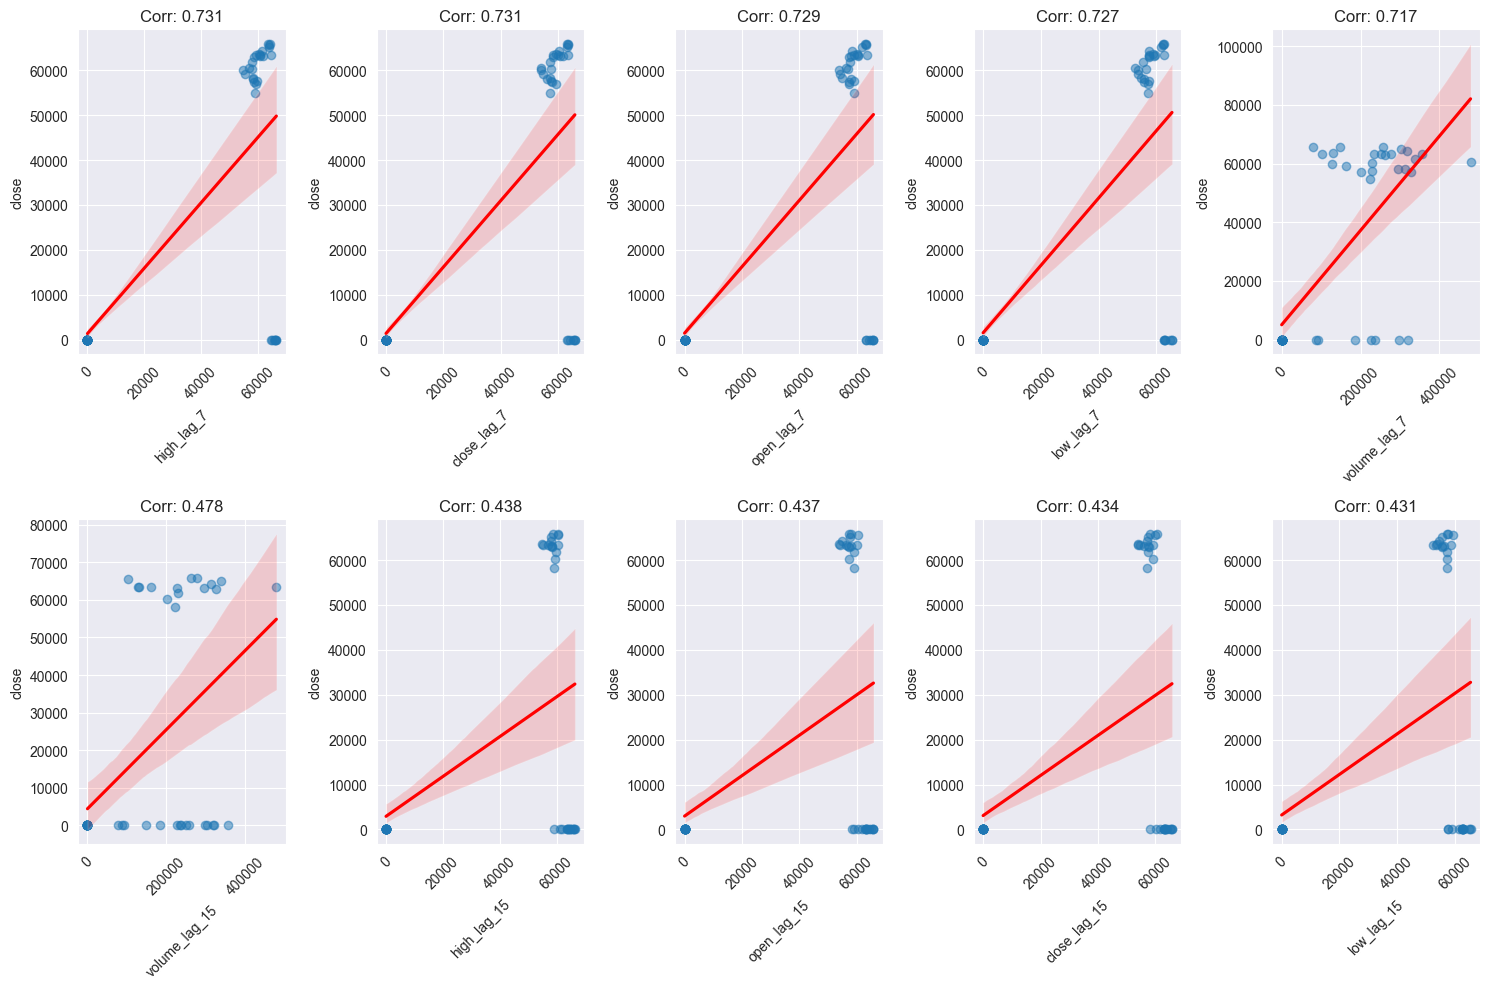


Top Correlations with Close:
      Feature  Correlation with Close
   high_lag_7                0.731225
  close_lag_7                0.730632
   open_lag_7                0.728902
    low_lag_7                0.726996
 volume_lag_7                0.716715
volume_lag_15                0.477631
  high_lag_15                0.437742
  open_lag_15                0.436648
 close_lag_15                0.433881
   low_lag_15                0.430903


In [487]:
# Get the correlations with Close, sort them, and create a DataFrame
correlations = daily_train_df[['close'] + lag_columns].corr()['close'].sort_values(ascending=False)
top_correlations = correlations[1:11]  # Excluding Close itself, taking top 10

# Create a scatter plot matrix for the top correlated variables
top_vars = top_correlations.index.tolist()
plt.figure(figsize=(15, 10))

# Create scatter plots with regression lines
for idx, var in enumerate(top_vars, 1):
    plt.subplot(2, 5, idx)
    sns.regplot(data=daily_train_df, x=var, y='close', scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.title(f'Corr: {correlations[var]:.3f}')
    plt.xlabel(var, rotation=45)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Create a DataFrame with the correlation values
correlation_df = pd.DataFrame({
    'Feature': top_correlations.index,
    'Correlation with Close': top_correlations.values
})

# Display the correlation DataFrame
print("\nTop Correlations with Close:")
print(correlation_df.to_string(index=False))

Test Predictions vs Actual:
Date: 2024-10-01, Actual: 60805.78, Predicted: 60347.05
Date: 2024-10-02, Actual: 60649.28, Predicted: 58780.25
Date: 2024-10-03, Actual: 60752.71, Predicted: 59170.21
Date: 2024-10-04, Actual: 62086.00, Predicted: 59170.21
Date: 2024-10-05, Actual: 62058.00, Predicted: 59170.21
Date: 2024-10-06, Actual: 62819.91, Predicted: 59170.21
Date: 2024-10-07, Actual: 62224.00, Predicted: 59170.21
Date: 2024-10-08, Actual: 62160.49, Predicted: 59841.02
Date: 2024-10-09, Actual: 60636.02, Predicted: 59841.02
Date: 2024-10-10, Actual: 60326.39, Predicted: 59841.02
Date: 2024-10-11, Actual: 62540.00, Predicted: 59841.02
Date: 2024-10-12, Actual: 63206.22, Predicted: 59841.02
Date: 2024-10-13, Actual: 62870.02, Predicted: 59841.02
Date: 2024-10-14, Actual: 66083.99, Predicted: 59841.02
Date: 2024-10-15, Actual: 67074.14, Predicted: 59841.02
Date: 2024-10-16, Actual: 67620.01, Predicted: 62414.51
Date: 2024-10-17, Actual: 67421.78, Predicted: 62414.51
Date: 2024-10-18, Ac

/var/folders/b5/v7fsmnzj7jg3tj7s1qq57q7w0000gn/T/ipykernel_98584/2989401084.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b.-" (-> marker='.'). The keyword argument will take precedence.
  plt.plot(daily_test_df['open_time'].iloc[:-1],
/var/folders/b5/v7fsmnzj7jg3tj7s1qq57q7w0000gn/T/ipykernel_98584/2989401084.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(daily_train_df['open_time'].iloc[30:],


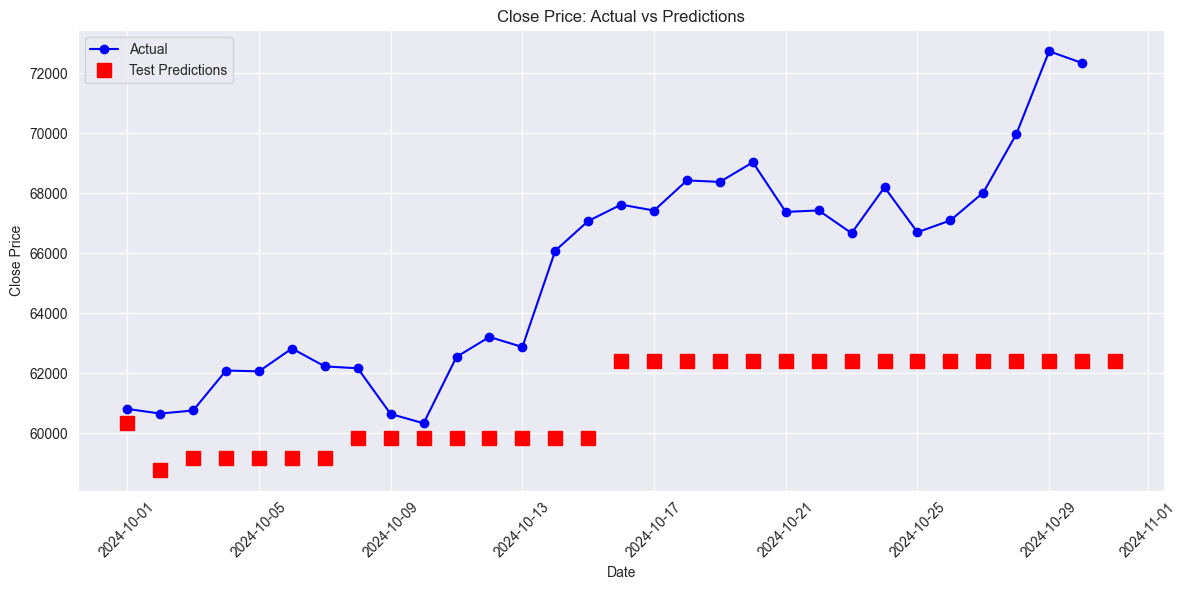

In [488]:

features = ['close_lag_7', 'high_lag_7', 'low_lag_7', 'open_lag_7',
            'close_lag_15', 'low_lag_15', 'high_lag_15', 'open_lag_15']

# Split data:
# Everything except last 3 rows -> training
# 2 rows before last -> test
# Last row -> forecast
X_train = daily_train_df[features][:-34]
y_train = daily_train_df['close'][:-34]

X_test = daily_train_df[features].iloc[-31:]
y_test = daily_train_df['close'].iloc[-31:]

# Train XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=10000,
    learning_rate=0.1,
    max_depth=1000,
    random_state=42
)

model.fit(X_train, y_train)

# Make predictions
test_predictions = model.predict(X_test)

# Create visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(daily_test_df['open_time'].iloc[:-1],
         daily_test_df['close'].iloc[:-1],
         'b.-', label='Actual', marker='o')

# Plot test predictions
plt.plot(daily_train_df['open_time'].iloc[30:],
         test_predictions,
         'r.', label='Test Predictions', marker='s', markersize=10)

plt.title('Close Price: Actual vs Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Print metrics
print("Test Predictions vs Actual:")
for date, actual, pred in zip(daily_test_df['open_time'], daily_test_df['close'], test_predictions):
    print(f"Date: {date}, Actual: {actual:.2f}, Predicted: {pred:.2f}")

# Calculate test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nTest Metrics:")
print(f"RMSE: {test_rmse:.2f}")
#print(f"R2 Score: {test_r2:.4f}")

plt.show()